<a href="https://colab.research.google.com/github/pranav168/Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [131]:
from google.colab import drive                                                  #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [264]:
import pandas as pd                                                             #loading all the Required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.ensemble import IsolationForest  
import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [133]:
df= pd.read_excel('/content/drive/MyDrive/Copy of Online Retail.xlsx')          #Loading the Dataset

In [134]:
df.info()                                                                       #Data contains a lot of Nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [135]:
df.isna().sum()                                                                 #135080 nulls in Customer id and 1454 nulls in Description

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [136]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [137]:
column_list=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                           #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['CustomerID','Description']:                                                                    #colur red shows the  Variable with missing values
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,InvoiceNo,InvoiceNo_count,StockCode,StockCode_count,Description,Description_count,Quantity,Quantity_count,InvoiceDate,InvoiceDate_count,UnitPrice,UnitPrice_count,CustomerID,CustomerID_count,Country,Country_count
0,573585,1114,85123A,2313,WHITE HANGING HEART T-LIGHT HOLDER,2369,1,148227,2011-10-31 14:41:00,1114,1.250000,50496,17841.000000,7983,United Kingdom,495478
1,581219,749,22423,2203,REGENCY CAKESTAND 3 TIER,2200,2,81829,2011-12-08 09:28:00,749,1.650000,38181,14911.000000,5903,Germany,9495
2,581492,731,85099B,2159,JUMBO BAG RED RETROSPOT,2159,12,61063,2011-12-09 10:03:00,731,0.850000,28497,14096.000000,5128,France,8557
3,580729,721,47566,1727,PARTY BUNTING,1727,6,40868,2011-12-05 17:24:00,721,2.950000,27768,12748.000000,4642,EIRE,8196
4,558475,705,20725,1639,LUNCH BAG RED RETROSPOT,1638,4,38484,2011-06-29 15:58:00,705,0.420000,24533,14606.000000,2782,Spain,2533
5,579777,687,84879,1502,ASSORTED COLOUR BIRD ORNAMENT,1501,3,37121,2011-11-30 15:13:00,687,4.950000,19040,15311.000000,2491,Netherlands,2371
6,581217,676,22720,1477,SET OF 3 CAKE TINS PANTRY DESIGN,1473,24,24021,2011-12-08 09:20:00,676,3.750000,18600,14646.000000,2085,Belgium,2069
7,537434,675,22197,1476,PACK OF 72 RETROSPOT CAKE CASES,1385,10,22288,2010-12-06 16:57:00,675,2.100000,17697,13089.000000,1857,Switzerland,2002
8,580730,662,21212,1385,LUNCH BAG BLACK SKULL.,1350,8,13129,2011-12-05 17:28:00,662,2.460000,17091,13263.000000,1677,Portugal,1519
9,538071,652,20727,1350,NATURAL SLATE HEART CHALKBOARD,1280,5,11757,2010-12-09 14:09:00,652,2.080000,17005,14298.000000,1640,Australia,1259


In [138]:
final_tally                                                                     # Gives (No. of unique elements in Variable, Total of all Variable, Total of Top 10 Variable )                                                          

[('InvoiceNo', (25900, 541909, 7372)),
 ('StockCode', (4070, 541909, 17231)),
 ('Description', (4223, 540455, 17082)),
 ('Quantity', (722, 541909, 478787)),
 ('InvoiceDate', (23260, 541909, 7372)),
 ('UnitPrice', (1630, 541909, 258908)),
 ('CustomerID', (4372, 406829, 36188)),
 ('Country', (38, 541909, 533479))]

here important thing to note is that :


1.   Only 25900 unique Invoice
2.   Only 4070 unique StokeCode(which means number of products =4070)
3.   There are only 4372 Unique Customers (thus we should look a way to group data as per customers, thus we will have to treat the customers with Nan values as similar.
4.  only 38 Country of which 10 country represents almost entire data, and UK alone explain 90% Data thus we will group country 'UK' as 1 and 'Others' as 0.
5.  Also well be droping Description Coulmns as we already have Stockcode for product mapping also their are few Nan in Description Coulmns.



In [139]:
df['Order Status']=df['InvoiceNo'].apply(lambda x: np.where(str(x)[0]=='C',0,1))                 #As there are some Canceled Data in the Transaction well be marking them as '0'.
print(df['Order Status'].value_counts())                                                         #Counting the Number of Canceled Orders.
try:
  df.drop('Description',axis=1,inplace=True)
  df.dropna(inplace=True)
except:
  pass
df['Country']=df['Country'].apply(lambda x: np.where(x=='United Kingdom','1','0'))
df.head()

1    532621
0      9288
Name: Order Status, dtype: int64


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order Status
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,1,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,1,1
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,1,1
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,1,1
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,1,1


In [140]:
df.describe()                                                                   #their is Negative Values in Quantity lets explore this column

,Quantity,UnitPrice,CustomerID,Order Status
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,0.978111
std,248.693370,69.315162,1713.600303,0.146321
min,-80995.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13953.000000,1.000000
50%,5.000000,1.950000,15152.000000,1.000000
75%,12.000000,3.750000,16791.000000,1.000000
max,80995.000000,38970.000000,18287.000000,1.000000


In [141]:
df[df.Quantity<=0].head()                                                        #these are all Canceled Transanctions thus products are returned we can now remove InvoiceNo as we have saved that feature in order status
try:                                                    
  df.drop('InvoiceNo',axis=1,inplace=True)
except:
  pass

In [142]:
df['Temp_col']=df['StockCode'].apply(lambda x: np.where(len(str(x))==5,1,0))    # As stock code be a number of 5 digit we should look at the anomalies over here
print(df.Temp_col.value_counts())
df[df['Temp_col']==0].head()                                                    # Nothing conclusive found thus i will retain these values for futher and Dropping the temp column
try:
  df.drop('Temp_col',axis=1,inplace=True)
except:
  pass

1    371020
0     35809
Name: Temp_col, dtype: int64


In [143]:
print(type(df['InvoiceDate'][0]))                                               #Time stamp format
max_date=df['InvoiceDate'].max()
print(max_date)                                                                 #Lets take is date as a refrence for the Last Transaction, thus we will now compute the Last date of each transaction 
print(df['InvoiceDate'].min())
df['Days Before Last Trans']=df['InvoiceDate'].apply(lambda x: (max_date-x).days )

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2011-12-09 12:50:00
2010-12-01 08:26:00


In [144]:
try:
  df.drop('InvoiceDate',axis=1,inplace=True)                                    # Dropping Invoice as it is of no use now
except:
  pass
df.head()

,StockCode,Quantity,UnitPrice,CustomerID,Country,Order Status,Days Before Last Trans
0,85123A,6,2.55,17850.0,1,1,373
1,71053,6,3.39,17850.0,1,1,373
2,84406B,8,2.75,17850.0,1,1,373
3,84029G,6,3.39,17850.0,1,1,373
4,84029E,6,3.39,17850.0,1,1,373


In [145]:
df['Amount']=df['Quantity']*df['UnitPrice']                                     #Multiplying Qnt and Price per unit to get Amount, and then Droping Both the Columns
try:
  df.drop(['Quantity','UnitPrice'],axis=1,inplace=True)
except:
  pass
df.head()

,StockCode,CustomerID,Country,Order Status,Days Before Last Trans,Amount
0,85123A,17850.0,1,1,373,15.30
1,71053,17850.0,1,1,373,20.34
2,84406B,17850.0,1,1,373,22.00
3,84029G,17850.0,1,1,373,20.34
4,84029E,17850.0,1,1,373,20.34


In [146]:
one_hot_entity=['Order_Status']    
column_one_hot=['Order Status']                                                 #One hot encoding of Order Status so as to get the gist of number of successful, canceled orders
count=0
for i in column_one_hot:
  temp_df=pd.get_dummies(df[i], prefix=one_hot_entity[count])
  count+=1
  df=pd.concat([df, temp_df], axis=1)
try:
  df.drop('Order Status',axis=1,inplace=True)                                   #Dropping Order Status of no use now
except:
  pass
df.head()

,StockCode,CustomerID,Country,Days Before Last Trans,Amount,Order_Status_0,Order_Status_1
0,85123A,17850.0,1,373,15.30,0,1
1,71053,17850.0,1,373,20.34,0,1
2,84406B,17850.0,1,373,22.00,0,1
3,84029G,17850.0,1,373,20.34,0,1
4,84029E,17850.0,1,373,20.34,0,1


In [297]:
df1=df.groupby('CustomerID')['StockCode'].count()                               # Our Features are now ready and thus i will be making the Final Dataset
df2=df.groupby('CustomerID')['Country'].max()
df3=df.groupby('CustomerID')['Order_Status_0'].sum()
df4=df.groupby('CustomerID')['Order_Status_1'].sum()
df5=df.groupby('CustomerID')['Days Before Last Trans'].min()
df6=df.groupby('CustomerID')['Amount'].sum()
columns=['Country','Order_Status_0','Order_Status_1','Days Before Last Trans','Amount']
data_frames=[df2,df3,df4,df5,df6]
final_df=pd.DataFrame(df1)
count=0
for i in columns:
  final_df[i]=data_frames[count]
  count+=1

In [298]:
print(final_df.shape)
final_df.head()                                                                 #Our Final Dataset is Completely Ready

(4372, 6)


,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount
CustomerID,,,,,,
12346.0,2,1,1,1.0,325,0.00
12347.0,182,0,0,182.0,1,4310.00
12348.0,31,0,0,31.0,74,1797.24
12349.0,73,0,0,73.0,18,1757.55
12350.0,17,0,0,17.0,309,334.40


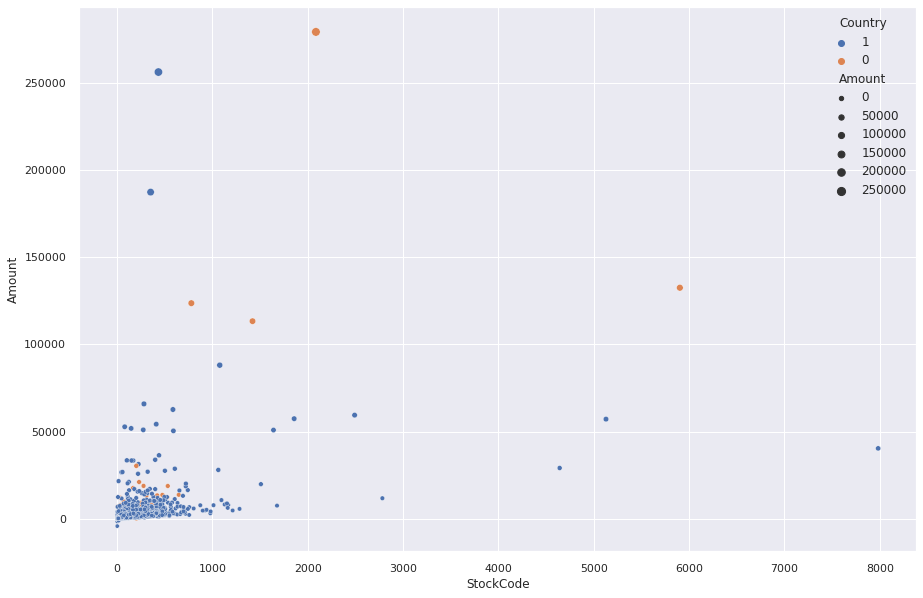

In [299]:
def plot_scatter(final_df,hue='Country'):
  sns.scatterplot(final_df.StockCode,final_df['Amount'],hue=final_df[hue],size=final_df['Amount'],size_order=(5,15))
  plt.show()       
                                                                                #Essentially all these outliers are wholesalers(already clusted and buisness), it would be good if we can remove them and cluster them on our own
plot_scatter(final_df)

(3817, 9)


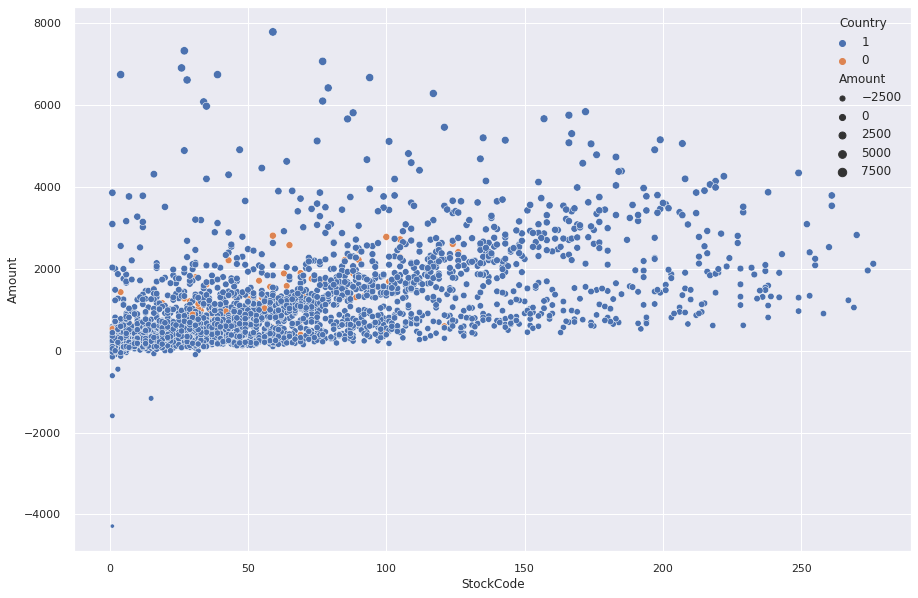

In [322]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(final_df[['StockCode','Country','Order_Status_0','Order_Status_1','Days Before Last Trans','Amount']])
clf = IsolationForest(n_estimators=100, contamination=0.04, random_state=0)     #Isolation Forest algorithm for anomaly detection
clf.fit(X)

final_df['multivariate_anomaly_score'] = clf.decision_function(X)                     # predict raw anomaly score
final_df['multivariate_outlier'] = clf.predict(X)                                     # prediction of a datapoint category outlier or inlier
df_wholesalers=final_df[final_df.multivariate_outlier==-1]
final_df=final_df[final_df.multivariate_outlier==1]                                               #updating data
print(final_df.shape)  #outliers have been removed
final_df.drop(['multivariate_anomaly_score','multivariate_outlier'],axis=1,inplace=True)
plot_scatter(final_df)

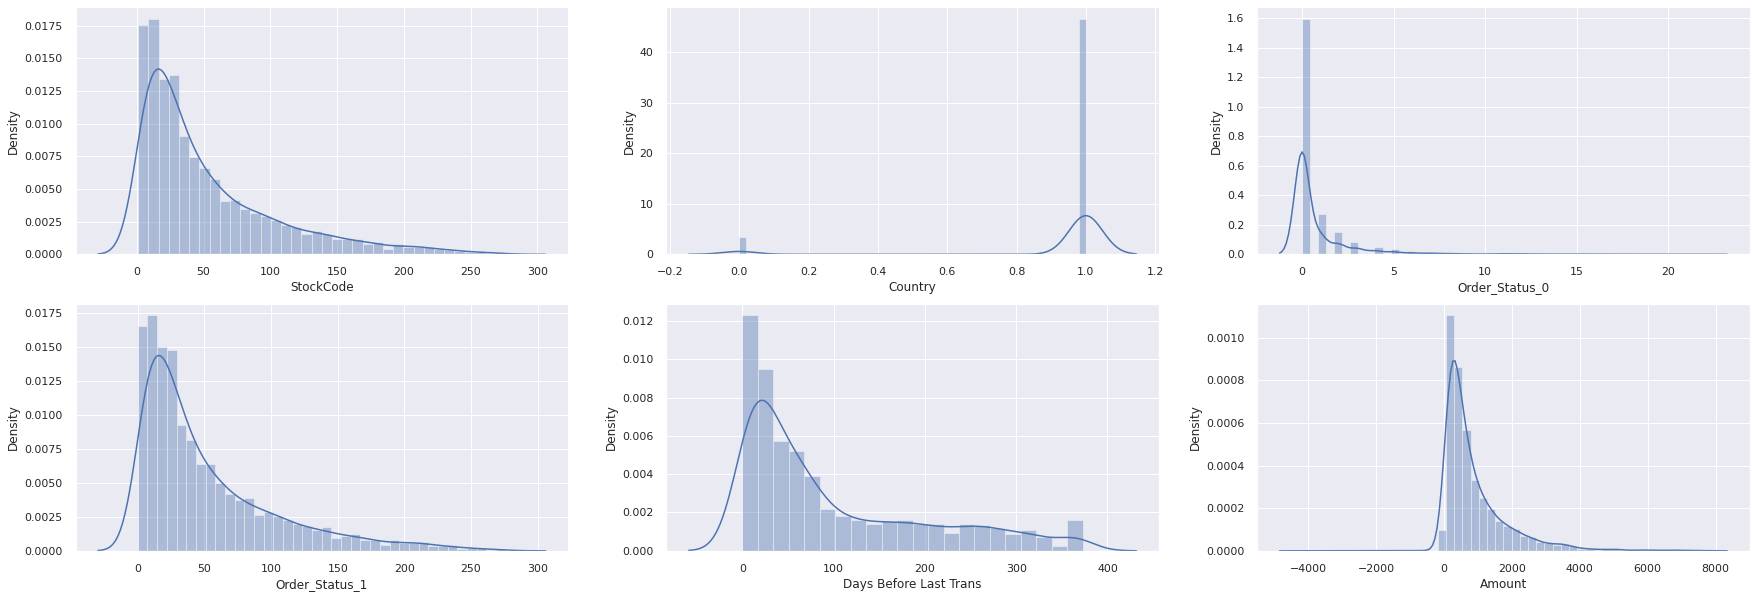

In [346]:
def plot_dist(final_df,fig_size=(30,10),plot_type=0):
  columns=['StockCode','Country','Order_Status_0','Order_Status_1','Days Before Last Trans','Amount']
  fig,ax=plt.subplots(2,3,figsize=fig_size)
  count=0
  counter=0
  for i in columns:
    if plot_type==0:
      sns.distplot(final_df[i],ax=ax[count,counter])
    else:
      sns.countplot(final_df[i],ax=ax[count,counter])
    counter+=1
    if counter==3:
      counter=0
      count=1
    plt.show
plot_dist(final_df)

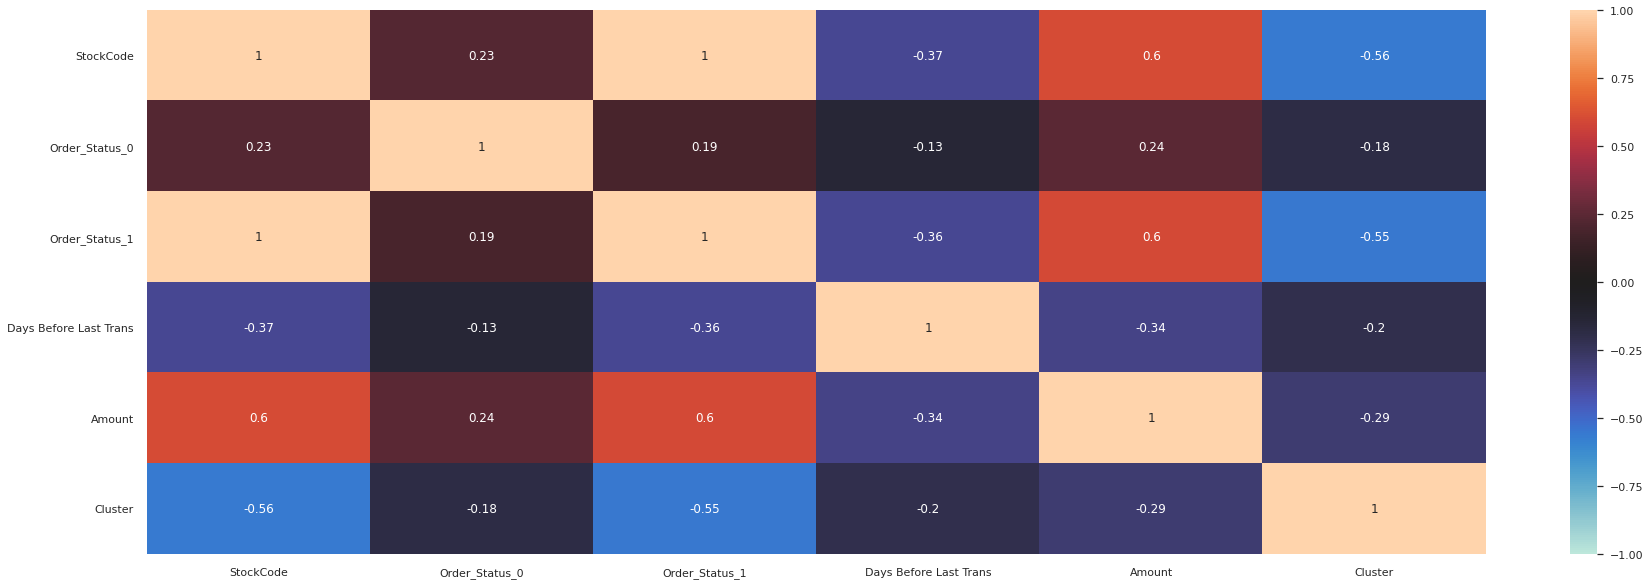

In [324]:
a = final_df.corr()
plt.figure(figsize=(30,10))
sns.heatmap(a,vmin=-1,vmax=1,center=0,annot=True)

For n_clusters = 2, silhouette score is 0.3731991660490946


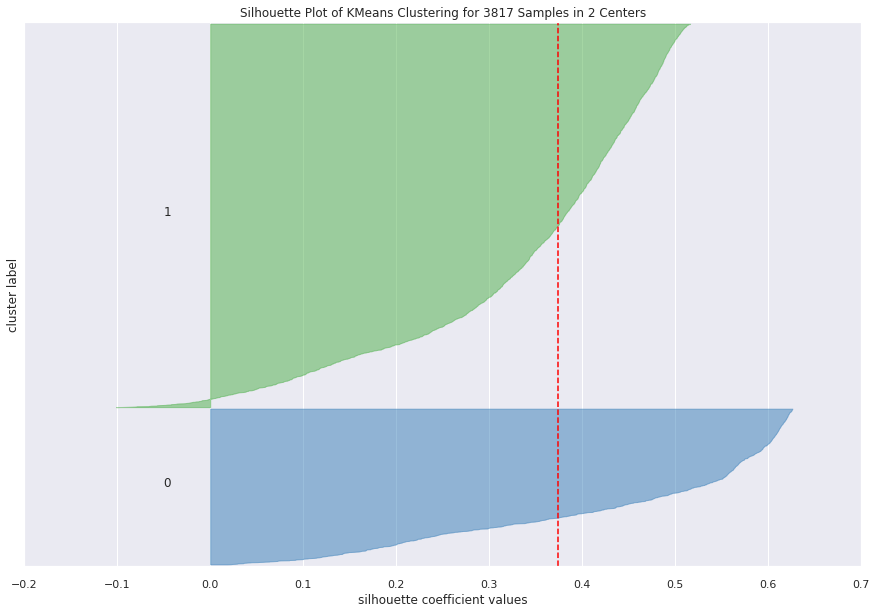

For n_clusters = 3, silhouette score is 0.4417195341507027


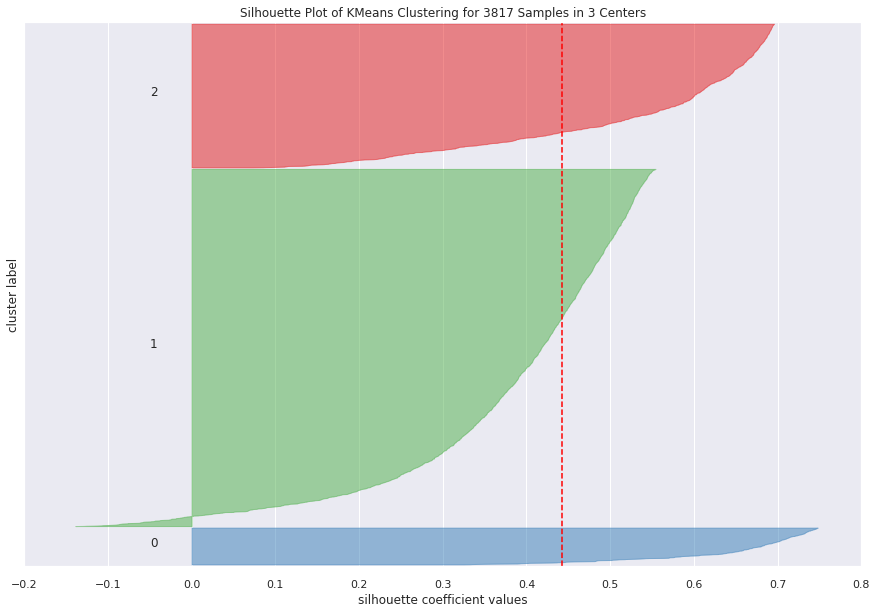

For n_clusters = 4, silhouette score is 0.48961665589995007


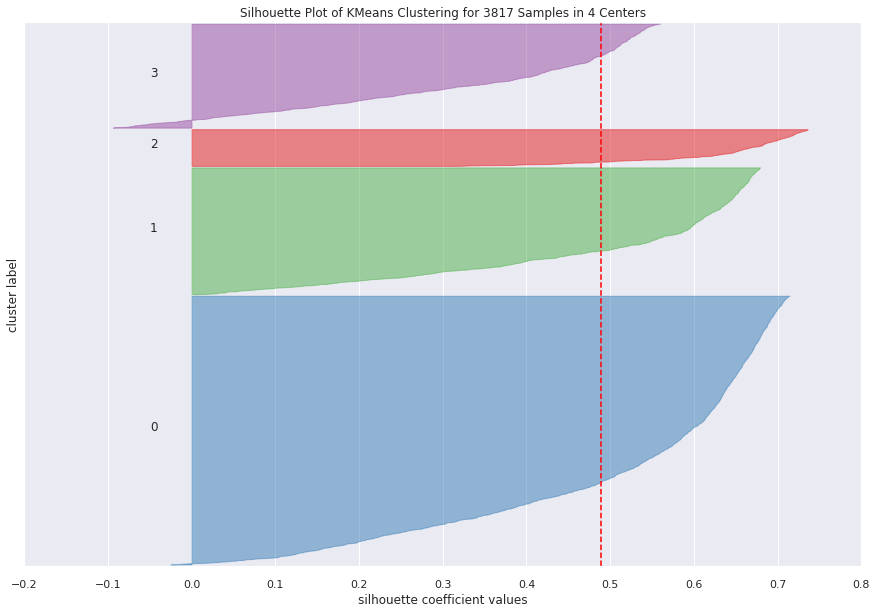

For n_clusters = 5, silhouette score is 0.43710532759524884


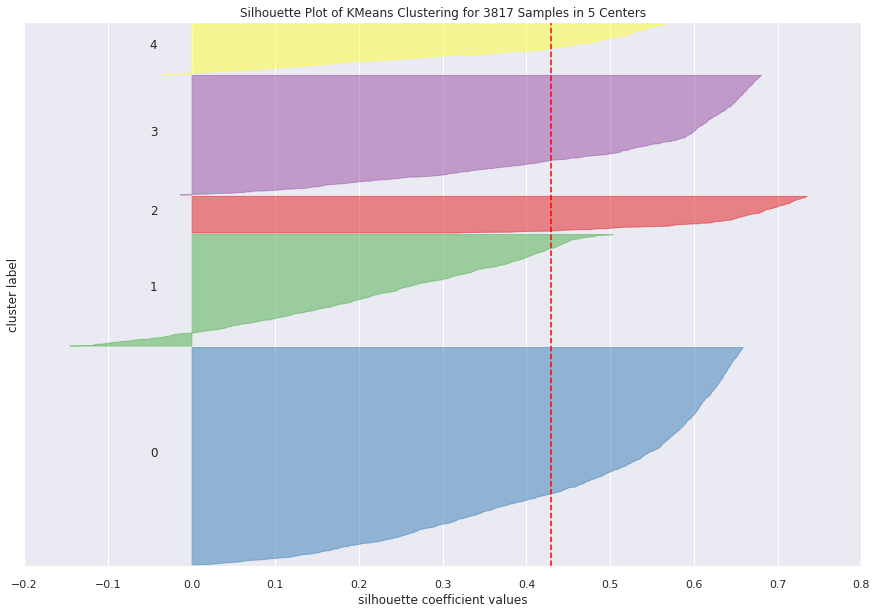

In [325]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(final_df[['StockCode','Country','Order_Status_0','Order_Status_1','Days Before Last Trans','Amount']])
def silhouette_score_analysis(n): 
  for n_clusters in range(2,n):
      km = KMeans (n_clusters=n_clusters, max_iter=100,tol=0.01)
      preds = km.fit_predict(X)
      centers = km.cluster_centers_
      score = silhouette_score(X, preds, metric='euclidean')
      print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
      visualizer = SilhouetteVisualizer(km)
      visualizer.fit(X) 
      visualizer.poof() 
silhouette_score_analysis(6)                                                    # More than 5 Clusters would Not seem Logical for Buisness Point of view.                                       


As per Silhouette_score number of Cluster Could be 4

The innertia for : 2 Clusters is: 600.3725551820302
The innertia for : 3 Clusters is: 370.0633088474559
The innertia for : 4 Clusters is: 207.8096181018485
The innertia for : 5 Clusters is: 171.54255464686403
The innertia for : 6 Clusters is: 147.35170794396515
The innertia for : 7 Clusters is: 130.45682020400966
The innertia for : 8 Clusters is: 115.97212387633915
The innertia for : 9 Clusters is: 103.97136677834912


Text(0.5, 1.0, 'Inertia Plot per k')

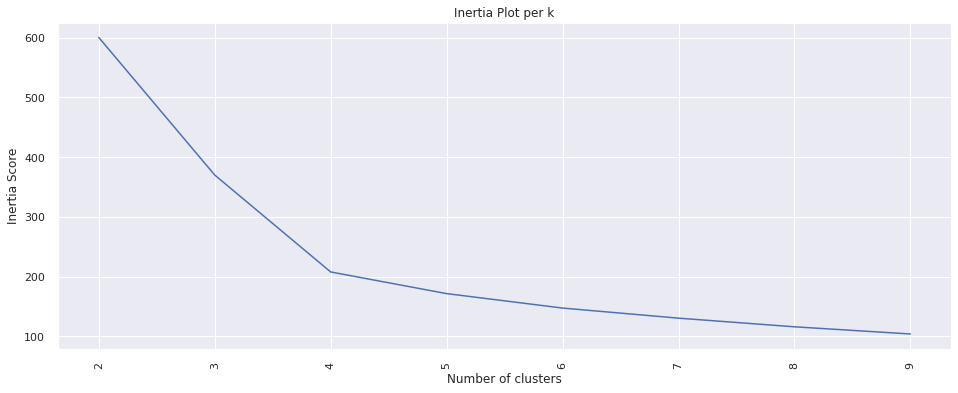

In [326]:
no_of_clusters = range(2,10)
inertia=[]
for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")                                                 # But As per innertia plot clusters=4.

In [327]:
kmeans = KMeans(n_clusters=4, random_state=2) 
kmeans = kmeans.fit(X)
kmeans.labels_
predictions = kmeans.predict(X)
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,4)
countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1","Cluster 2","Cluster 3"])
countscldf

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,912,1909,262,734


In [328]:
final_df['Cluster']=predictions
final_df.head()

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster
CustomerID,,,,,,,
12346.0,2,1,1,1.0,325,0.00,0
12348.0,31,0,0,31.0,74,1797.24,2
12349.0,73,0,0,73.0,18,1757.55,2
12350.0,17,0,0,17.0,309,334.40,2
12353.0,4,0,0,4.0,203,89.00,2


Explained variance ratio (first two components): [0.4564862  0.28306468]


<Figure size 1080x720 with 0 Axes>

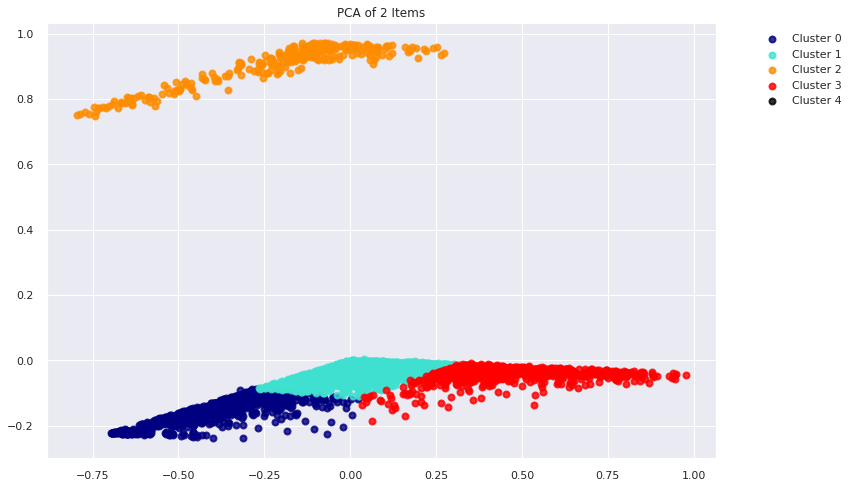

In [329]:
X = X
y_num = predictions
target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]
pca = PCA(n_components=2, random_state =1 )
X_r = pca.fit(X).transform(X)
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red','black']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3,4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

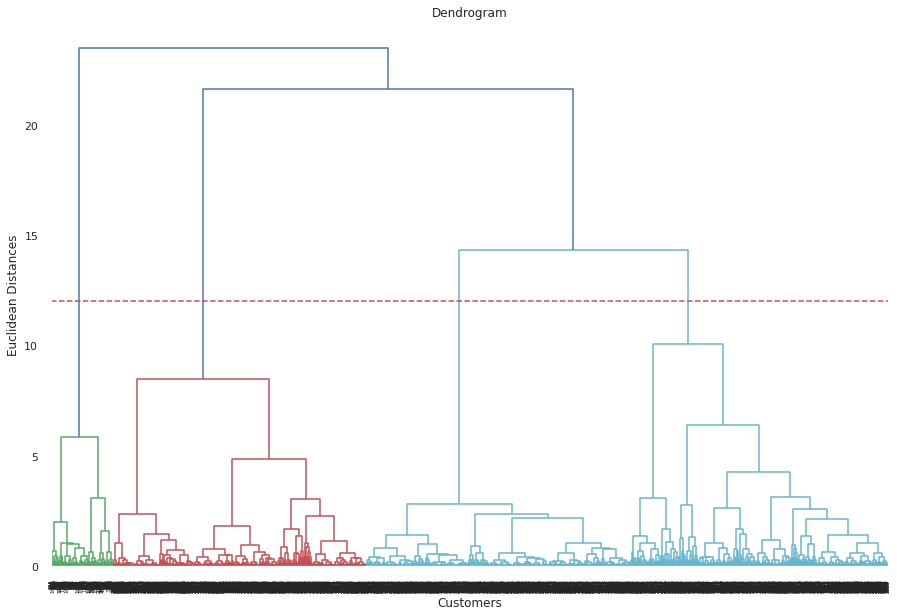

In [311]:
from pylab import rcParams                                                      #Doing Hierarchical Clustering and plotting a Dendogram to Visualize the Perfect value of K
rcParams['figure.figsize'] = 15, 10
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.axhline(y=12, color='r', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()                                                                      # 4 Cluster looks Good

Now, that we have 5 customer Segments ( 4 from Kmeans Clusters and 1 of wholesalers), Lets Define them

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster
CustomerID,,,,,,,
12346.0,2,1,1,1.0,325,0.00,0
12821.0,6,1,0,6.0,213,92.72,0
12829.0,12,1,1,11.0,321,253.05,0
12831.0,9,1,0,9.0,261,215.05,0
12834.0,18,1,0,18.0,282,312.38,0


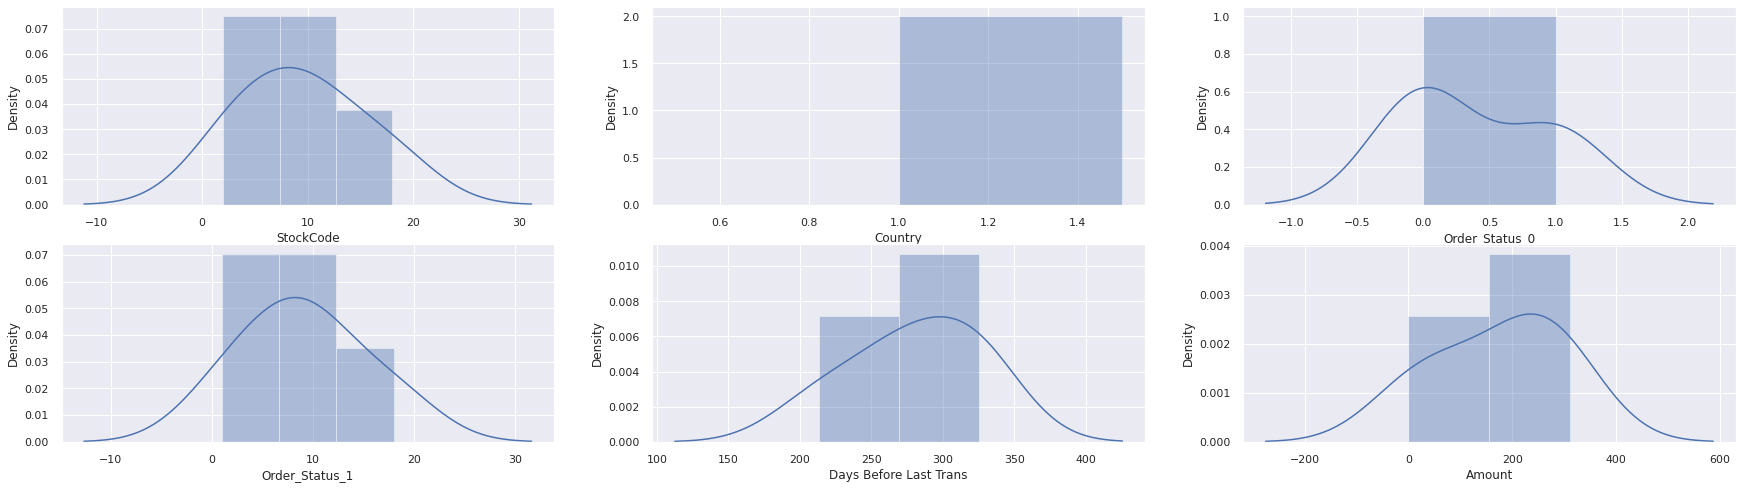

In [349]:
Cluster_0=final_df[final_df['Cluster']==0].head()
Cluster_1=final_df[final_df['Cluster']==1].head()   
Cluster_2=final_df[final_df['Cluster']==2].head() 
Cluster_3=final_df[final_df['Cluster']==3].head()

plot_dist(Cluster_0,fig_size=(30,8))
Cluster_0

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster
CustomerID,,,,,,,
12820.0,59,1,0,59.0,2,942.34,1
12822.0,47,1,1,46.0,70,918.98,1
12823.0,5,1,0,5.0,74,1759.50,1
12824.0,25,1,0,25.0,59,397.12,1
12827.0,25,1,0,25.0,5,430.15,1


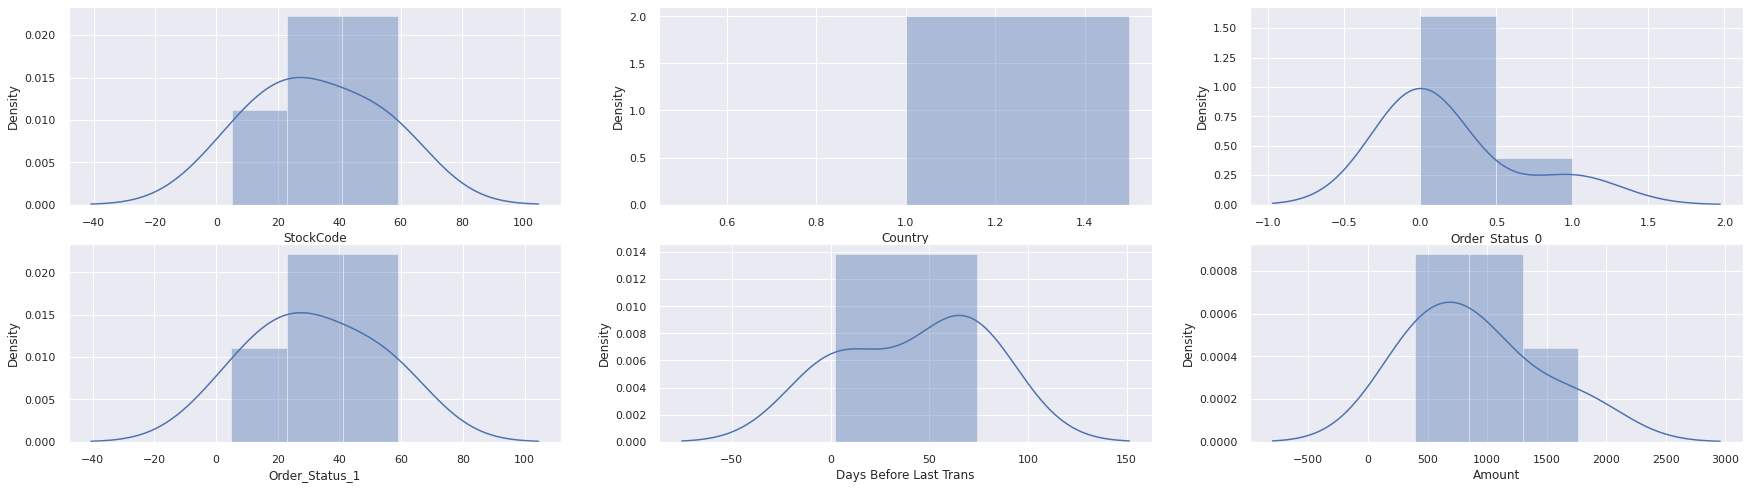

In [340]:
plot_dist(Cluster_1,fig_size=(30,8))
Cluster_1

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster
CustomerID,,,,,,,
12348.0,31,0,0,31.0,74,1797.24,2
12349.0,73,0,0,73.0,18,1757.55,2
12350.0,17,0,0,17.0,309,334.40,2
12353.0,4,0,0,4.0,203,89.00,2
12354.0,58,0,0,58.0,231,1079.40,2


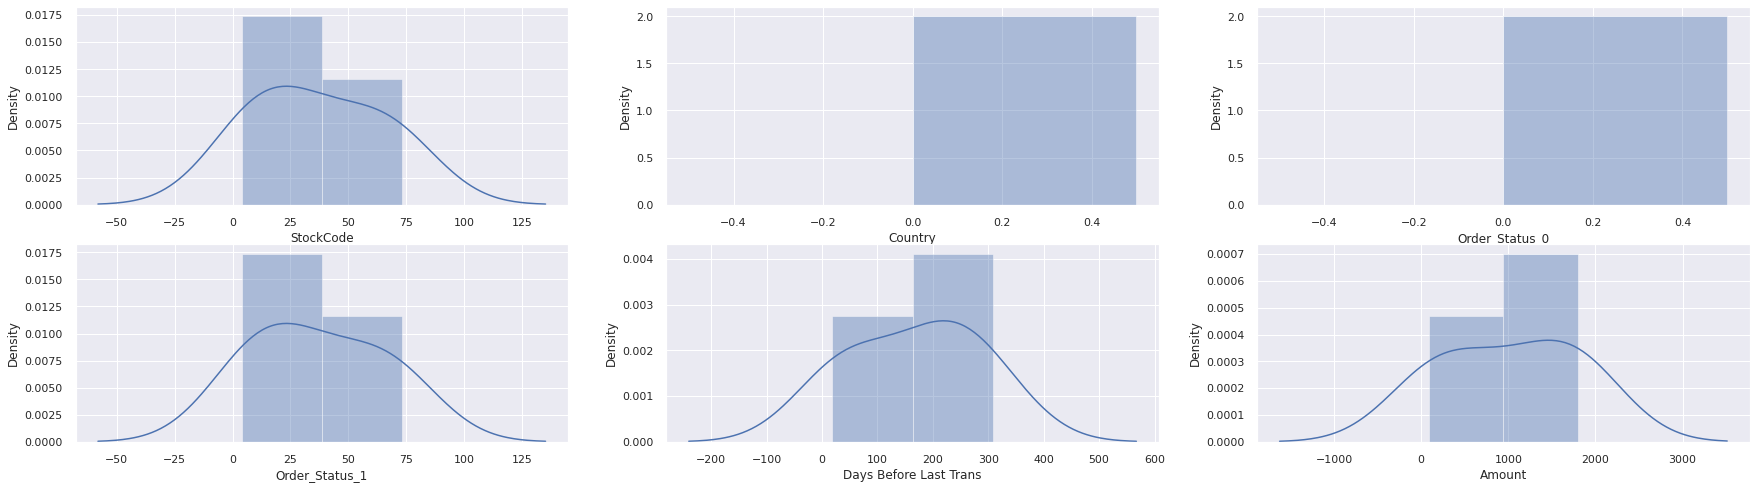

In [341]:
plot_dist(Cluster_2,fig_size=(30,8))
Cluster_2

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster
CustomerID,,,,,,,
12747.0,103,1,0,103.0,1,4196.01,3
12826.0,94,1,3,91.0,2,1468.12,3
12836.0,175,1,0,175.0,58,2612.86,3
12838.0,123,1,0,123.0,33,683.13,3
12840.0,116,1,3,113.0,143,2714.27,3


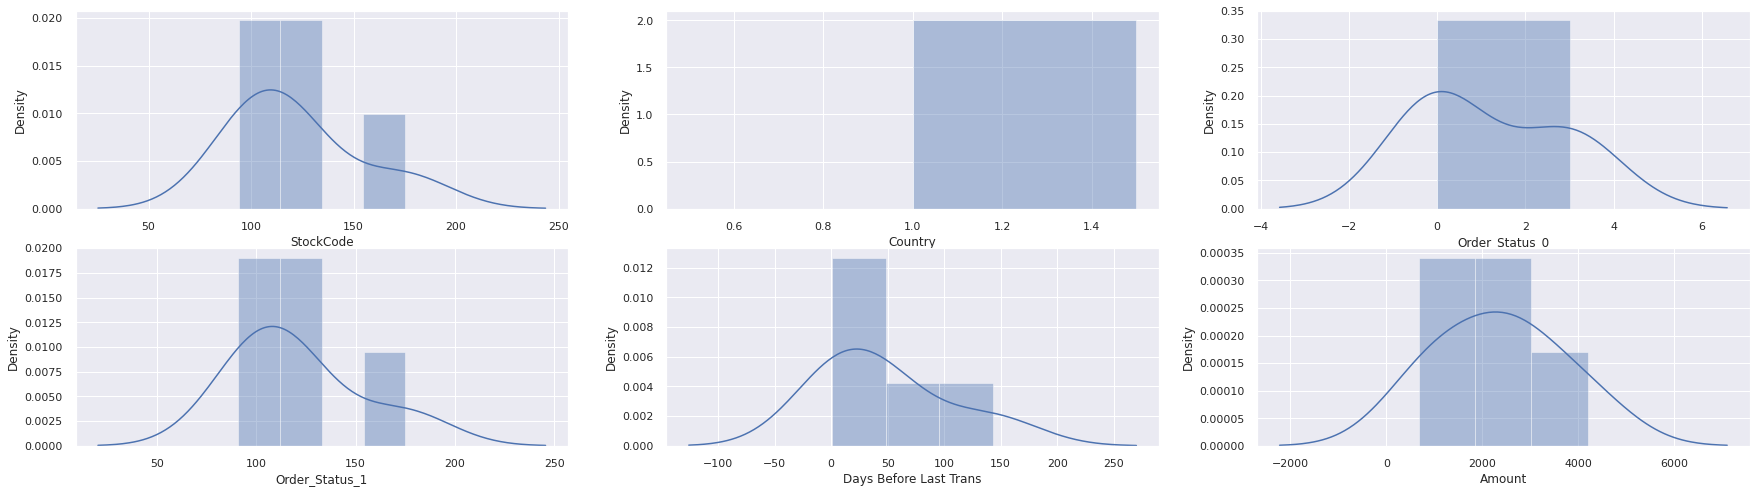

In [342]:
plot_dist(Cluster_3,fig_size=(30,8))
Cluster_3

,StockCode,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Amount,Cluster,multivariate_anomaly_score,multivariate_outlier
CustomerID,,,,,,,,,
12360.0,129,0,0,129.0,51,2662.06,3,-0.008431,-1
12381.0,91,0,4,87.0,4,1803.96,3,-0.022166,-1
12406.0,108,0,3,105.0,21,3280.75,3,-0.030400,-1
12410.0,28,0,2,26.0,300,681.08,3,-0.013900,-1
12423.0,126,0,1,125.0,0,1849.11,3,-0.000434,-1


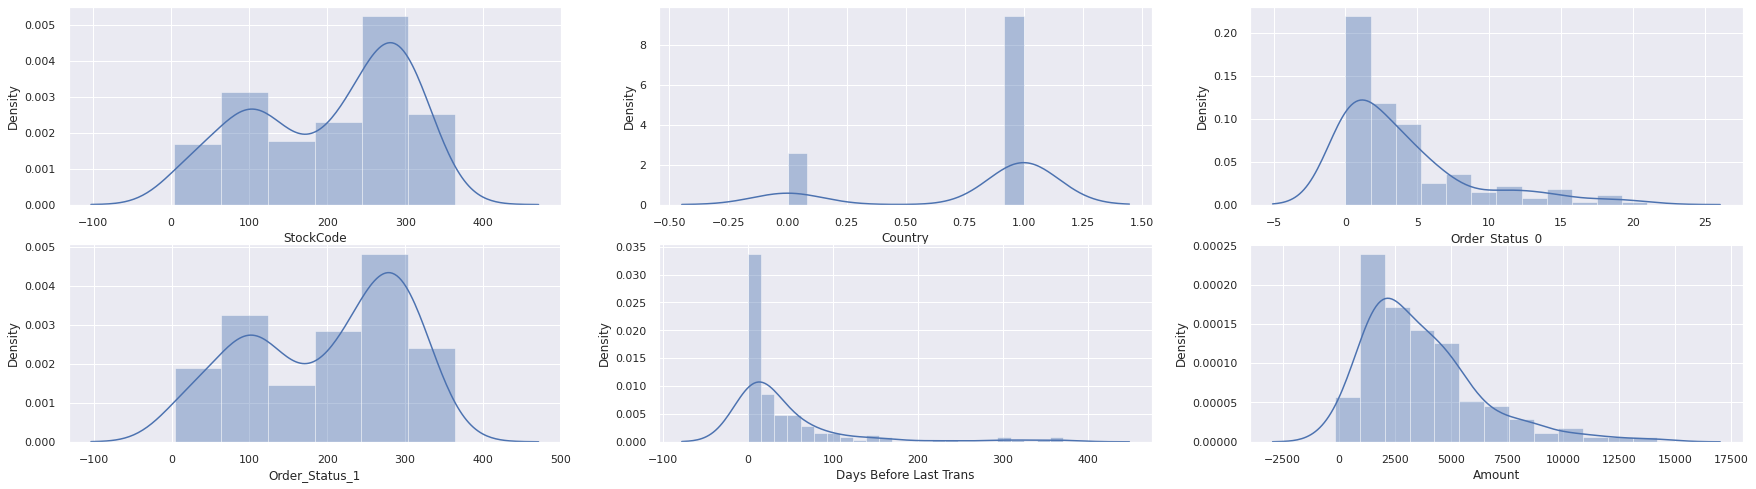

In [343]:
plot_dist(df_wholesalers,fig_size=(30,8))
df_wholesalers.head()